<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2020_2021/blob/main/ChannelFlow/ChannelFlow_BasicModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import odeint
from pylab import *
from IPython.display import Math

In [2]:
%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (12, 3)

In [4]:
T = 44712 # tide period
L = 20000 # channel length [m]
h = 60    # channel depth [m]
b = 4000  # channel width [m]
a = 1.2   # tidel amplitude [m]
S = h*b   # channel area [m^2]    
c = L/S   # \int S^-1 dx [1/m]

ρw = 1025   # salt water density [kg/m^3]
g   = 9.8    # gravity aceleration [m/s^2]

omega = 2*np.pi / T  # tidal frequency
q0 = g*a / (omega*c) # frictionless channel volumetric flow rate 

Cd  = 0.005 # friction coefficient [-]
f   = 2*Cd   # friction coefficient used in the model(slides)

C_T = 0.8

#==================================================
Aturb = 400.0   # area of 1 turbine [m^2] 
n_turbs = 60    # number of turbines [-]

B = n_turbs * Aturb / S  # blockage factor [-]
print( "B =", B)

#==================================================
λ0  = 0.5 * f * L / ( h * S**2 )
λ0s = q0**2 / (g*a) * λ0

n_turbs = 56

λ1  = B * C_T / ( 2 * S**2 )
λ1s = n_turbs*q0**2 / (g*a) * λ1

print( "lambda0s =", λ0s )
print( "lambda1s =", λ1s )

Fr0 = q0 / (S * np.sqrt(g*h) )
print( "Fr0 =", Fr0 )

B = 0.1
lambda0s = 2.481330058304763
lambda1s = 3.334907598361602
Fr0 = 0.1725571230046942


# Solution of the ODE

$\displaystyle \frac{dq^*}{dt^*}=\cos(t^*) - (\lambda_0^*+\lambda_1^*) \, q^* \, |q^*|$

The following function define the RHS of the ODE 

In [5]:
def dqs_dts( qs, ts, λ0s, λ1s ):
    return np.cos( ts ) - ( λ0s + λ1s ) * qs * np.abs( qs )

<IPython.core.display.Math object>

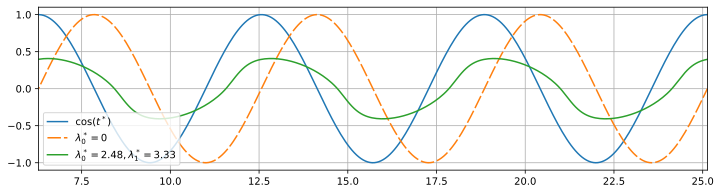

In [6]:
periods = 4
ppp = 100 # points per period
tsv = np.linspace( 0, 2*np.pi*periods, int(ppp*periods) )
qs0 = 0

sol = odeint( dqs_dts, qs0, tsv, args = (0,0) )
qs = sol.transpose()[0]

plot( tsv, np.cos(tsv), label="$\cos(t^*)$" )
plot(tsv, qs, dashes=(9,2), label="$\lambda_0^*=0$" )

sol = odeint( dqs_dts, qs0, tsv, args = (λ0s,λ1s) )
qs = sol.transpose()[0]
plot(tsv, qs, label="$\lambda_0^*=%.2f, \lambda_1^*=%.2f$" % (λ0s,λ1s) )

legend(loc="lower left")
ylim( (-1.1, 1.1) )
xlim( (2*np.pi, 2*np.pi*periods) )
grid()

qmax = np.max(qs[-ppp:])
umax = qmax * q0 / S

Math( r"q_\mathrm{max}^*=%.5f\\[3pt]"
      r"u_\mathrm{max}=%.3f" % ( qmax, umax ) )